In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import geopy

I will be exploring the files to see layout, if there are null values, duplicates or other issues that may exist within the data.

**DATA WRANGLING**

TEST DATA FILE EXPLORATION:

In [2]:
test = pd.read_csv('test.csv')
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


Analysis: There are no null values in this dataset. 
Observation: Perhaps the Date column needs to be converted from dtype object to dtype datetime.

C:\Users\mayra\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


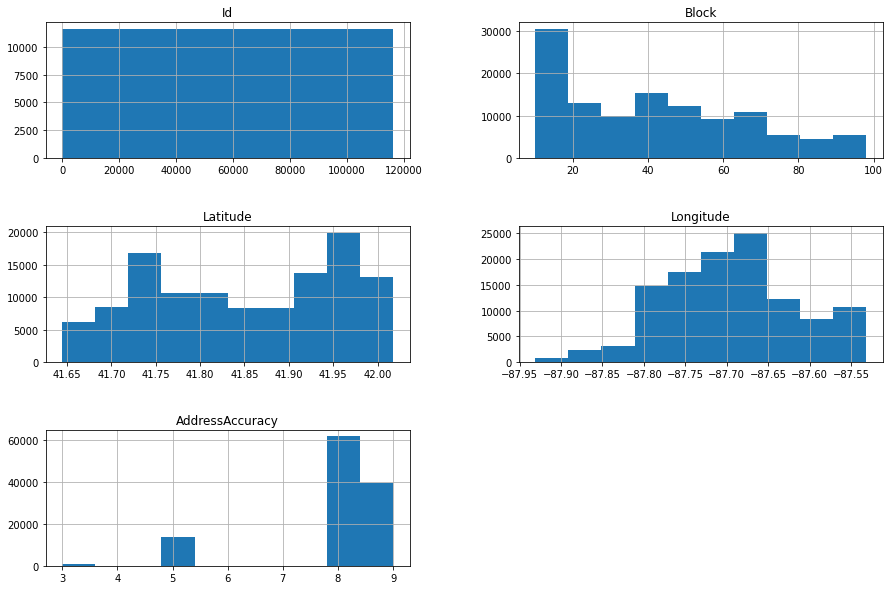

In [4]:
test.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

In [5]:
test.duplicated().value_counts()

False    116293
dtype: int64

There were no duplicated values in the dataset.

In [6]:
test.groupby('AddressAccuracy')['Id'].count()

AddressAccuracy
3      764
5    13761
8    61973
9    39795
Name: Id, dtype: int64

In [7]:
percent = 764/(764+13761+61973+39795)
print(percent*100,'%')

#AddressAccuracy = 3 makes up less than 1% of the data, it would be okay to drop it

0.6569612960367348 %


Summary of analysis on Test data file:
There were no duplicates in the data. There are a few rows where the AddressAccuracy has a low accuracy rate of 3, which makes up less than 1% of the entire data. This data could be dropped. 

Also, I tried to add a column to indicate if it was a satelite or not, but my for loop did not work. Also, the runtime is about 3 minutes, so I know there is a more efficient way. Per the Kaggle data overview, if the Trap code ends in a letter, then it is a Satelite. Since all of the others were in a 'XXXX' format, I thought I could label those with string length greater than 4 as 'Yes'. However, that did not work per above analysis (labeled as 'Yes' for those with 'XXXX'format...and the .nunique() function.

TRAIN DATA FILE EXPLORATION:

In [8]:
train = pd.read_csv('train.csv')
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [10]:
train.duplicated().value_counts()

False    9693
True      813
dtype: int64

In [11]:
train.drop_duplicates(keep='first',inplace=True)

In [12]:
train.duplicated().value_counts()

False    9693
dtype: int64

In [13]:
train.groupby('AddressAccuracy')['Date'].count()

AddressAccuracy
3      89
5    1302
8    4522
9    3780
Name: Date, dtype: int64

In [14]:
percent = 89/(89+1302+4522+3780)
percent

0.009181883833694419

In [15]:
#for i in test['Trap']:
 #   if len(i) > 4:
  #      test['Satelite_Trap'] = 'Yes'
   # else:
    #    test['Satelite_Trap'] = 'No'



In [16]:
#test['Satelite_Trap'].nunique()

In [17]:
#for i in test['Trap']:
    #if len(i) > 4:
        #print(i)

SPRAY DATA FILE EXPLORATION:

In [18]:
spray = pd.read_csv('spray.csv')
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [19]:
missing = pd.concat([spray.isnull().sum(), 100 * spray.isnull().mean()], axis=1)
header = missing.columns=['count', '%']
missing.sort_values(by=header, ascending=False)
#There are 584 missing values for time, which makes up 4% of the data.

,count,%
Time,584,3.936636
Date,0,0.000000
Latitude,0,0.000000
Longitude,0,0.000000


In [20]:
spray['Time'].sort_values().isnull()

8512     False
6731     False
11272    False
4702     False
11904    False
         ...  
1609      True
1610      True
1611      True
1612      True
1613      True
Name: Time, Length: 14835, dtype: bool

In [21]:
spray.iloc[1590:1613]

,Date,Time,Latitude,Longitude
1590,2011-09-07,NaN,41.992612,-87.813343
1591,2011-09-07,NaN,41.992660,-87.812767
1592,2011-09-07,NaN,41.992660,-87.812191
1593,2011-09-07,NaN,41.992612,-87.811663
1594,2011-09-07,NaN,41.992660,-87.811279
1595,2011-09-07,NaN,41.992660,-87.810847
1596,2011-09-07,NaN,41.992612,-87.810415
1597,2011-09-07,NaN,41.992660,-87.809455
1598,2011-09-07,NaN,41.992660,-87.809983
1599,2011-09-07,NaN,41.992708,-87.808927


Analysis: The Time Column had a few null values. Performed analysis to see what percent of the data was null. Only 4% of the data contained null values. It looks like all values are related to 2011-09-07. 

Observation: Perhaps we could concatenate the date and time columns to form a datetime datatype. 

In [22]:
spray['Date_Time'] = spray['Date'] + " " + spray['Time']
spray.head()

,Date,Time,Latitude,Longitude,Date_Time
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,2011-08-29 6:56:58 PM
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,2011-08-29 6:57:08 PM
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,2011-08-29 6:57:18 PM
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,2011-08-29 6:57:28 PM
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,2011-08-29 6:57:38 PM


In [23]:
spray['Date_Time'].value_counts().head(10)

2011-09-07 7:44:32 PM    541
2013-07-17 9:27:57 PM      2
2013-08-29 8:34:13 PM      2
2013-08-08 8:39:45 PM      2
2013-08-29 9:13:43 PM      2
2013-08-29 8:36:43 PM      2
2013-07-17 8:47:47 PM      2
2013-07-17 8:35:41 PM      2
2013-07-17 8:05:21 PM      2
2013-07-17 9:12:37 PM      2
Name: Date_Time, dtype: int64

Further analyzing the data to see if there are any anomalies. There are 541 rows that appear to be related to the same date as mentioned for the missing values (2011-09-07). Something funny is happening with this day. Could be related. However, in this case they appear to be duplicates.

In [24]:
spray['Lat_Lon'] = spray['Latitude'].astype(str) + ','+ spray['Longitude'].astype(str)
spray.head()
spray['Lat_Lon'].value_counts().sort_values(ascending=False).head(10)

41.98646,-87.794225                     541
41.9839166666667,-87.7930883333333        2
41.732623333333294,-87.6667066666667      1
42.00285,-87.7623516666667                1
42.010684999999995,-87.78321              1
41.972155,-87.802465                      1
41.9860839148307,-87.8032146150239        1
41.7687283333333,-87.7178833333333        1
41.9487466666667,-87.70923                1
41.928684999999994,-87.7831833333333      1
Name: Lat_Lon, dtype: int64

In [25]:
spray.duplicated().value_counts()

False    14294
True       541
dtype: int64

Confirmed they are duplicates. I also decided to drop the null values since they relate to the same day. I'd rather lose a day of data that is questionable and don't trust than to keep it.

In [26]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
 4   Date_Time  14251 non-null  object 
 5   Lat_Lon    14835 non-null  object 
dtypes: float64(2), object(4)
memory usage: 695.5+ KB


In [27]:
spray.drop_duplicates(keep='first',inplace=True)

In [28]:
spray.duplicated().value_counts()

False    14294
dtype: int64

In [29]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14294 entries, 0 to 14834
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14294 non-null  object 
 1   Time       13710 non-null  object 
 2   Latitude   14294 non-null  float64
 3   Longitude  14294 non-null  float64
 4   Date_Time  13710 non-null  object 
 5   Lat_Lon    14294 non-null  object 
dtypes: float64(2), object(4)
memory usage: 781.7+ KB


C:\Users\mayra\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


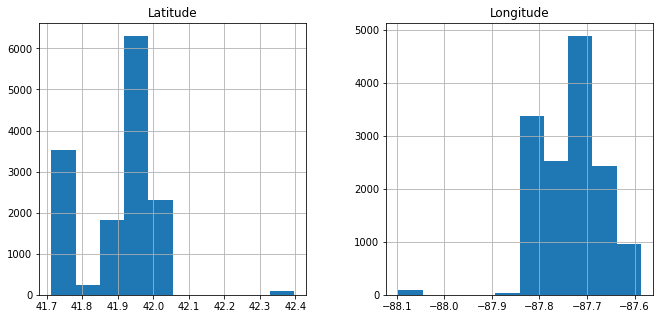

In [30]:
spray.hist(figsize=(11,5))
plt.subplots_adjust(hspace=0.5);

In [31]:
spray.dropna(inplace=True)

In [32]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13710 entries, 0 to 14834
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       13710 non-null  object 
 1   Time       13710 non-null  object 
 2   Latitude   13710 non-null  float64
 3   Longitude  13710 non-null  float64
 4   Date_Time  13710 non-null  object 
 5   Lat_Lon    13710 non-null  object 
dtypes: float64(2), object(4)
memory usage: 749.8+ KB


C:\Users\mayra\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


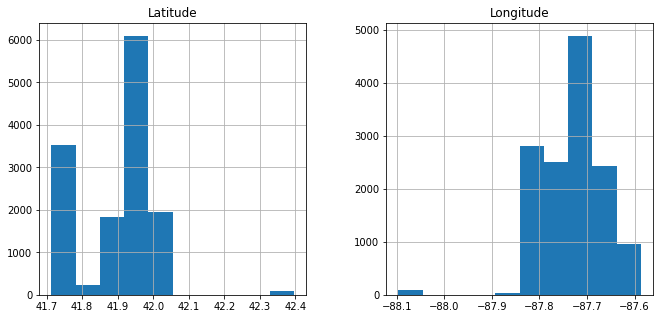

In [33]:
spray.hist(figsize=(11,5))
plt.subplots_adjust(hspace=0.5);

In [34]:
missing = pd.concat([spray.isnull().sum(), 100 * spray.isnull().mean()], axis=1)
header = missing.columns=['count', '%']
missing.sort_values(by=header, ascending=False)

,count,%
Date,0,0.0
Time,0,0.0
Latitude,0,0.0
Longitude,0,0.0
Date_Time,0,0.0
Lat_Lon,0,0.0


Summary of analysis on Spray data file:

Noticed there were 584 values that were null, which make-up 4% of the data. Also found there were 541 duplicates. All of these finding related to the same date, which made me question the data for that day. I'm certain that dropping the duplicates was correct, and made a choice to drop the null values (due to uncertainty of the validity of the data for that day).

WEATHER DATA FILE EXPLORATION:

In [35]:
weather = pd.read_csv('weather.csv')
weather.head().T

,0,1,2,3,4
Station,1,2,1,2,1
Date,2007-05-01,2007-05-01,2007-05-02,2007-05-02,2007-05-03
Tmax,83,84,59,60,66
Tmin,50,52,42,43,46
Tavg,67,68,51,52,56
Depart,14,M,-3,M,2
DewPoint,51,51,42,42,40
WetBulb,56,57,47,47,48
Heat,0,0,14,13,9
Cool,2,3,0,0,0


In [36]:
weather.sort_values(by='WetBulb',ascending=False)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
2410,1,2013-08-10,81,64,73,0,57,M,0,8,...,,0,M,0.0,0.00,M,30.08,5.3,5,6.5
2412,1,2013-08-11,81,60,71,-2,61,M,0,6,...,RA,0,M,0.0,0.01,29.35,30.07,2.0,27,3.0
848,1,2009-06-26,86,69,78,7,60,M,0,13,...,,0,M,0.0,0.00,M,29.85,6.4,4,8.2
2415,2,2013-08-12,85,69,77,M,63,M,0,12,...,RA,M,M,M,0.66,29.27,29.92,4.5,26,7.7
1628,1,2011-07-18,92,80,86,12,75,78,0,21,...,RA HZ,0,M,0.0,0.01,29.23,29.96,10.6,25,10.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,1,2008-10-28,45,31,38,-9,23,33,27,0,...,,0,M,0.0,0.00,29.54,30.29,10.5,30,10.9
729,2,2008-10-28,45,32,39,M,23,33,26,0,...,,M,M,M,0.00,29.60,30.31,9.9,30,10.3
1063,2,2009-10-11,45,29,37,M,23,33,28,0,...,,M,M,M,0.00,29.67,30.36,1.1,1,4.8
2942,1,2014-10-31,47,33,40,-6,25,33,25,0,...,RA SN,0,M,0.1,0.03,29.49,30.20,22.6,34,22.9


It looks like there are some columns that contain 'M' that probably shouldn't. However, I am not certain on that. I ready the Data Overview on Kaggle to see if 'M' represented anything and wasn't able to find anything. However, there seem to be quite a few cells with'M' and, aside from the average column, not sure how to handle the rest. 

C:\Users\mayra\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


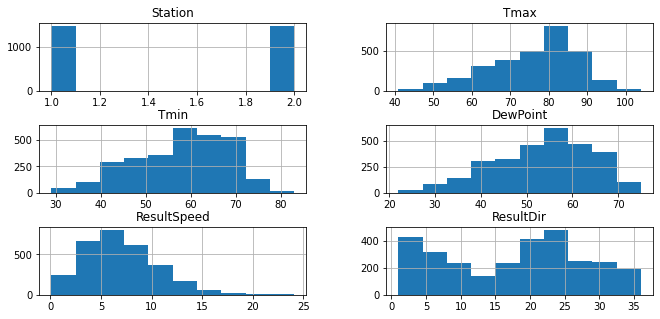

In [37]:
weather.hist(figsize=(11,5))
plt.subplots_adjust(hspace=0.5);

In [38]:
weather.duplicated().value_counts()

False    2944
dtype: int64

In [39]:
Tavg = len(weather[weather['Tavg'].str.contains('M')])
print(Tavg)

11


In [40]:
Depart = len(weather[weather['Depart'].str.contains('M')])
print(Depart)


1472


In [41]:
weather['Depart'].describe()

count     2944
unique      42
top          M
freq      1472
Name: Depart, dtype: object

In [42]:
weather['Depart'].unique()

array(['14', 'M', '-3', ' 2', ' 4', ' 5', '10', '12', '13', '-2', '15',
       '11', '-4', '-6', ' 8', '-5', ' 1', ' 9', ' 6', '-9', '-8', ' 3',
       ' 0', '-1', '-7', ' 7', '-14', '18', '16', '22', '21', '20', '-10',
       '-16', '17', '-12', '-11', '-15', '-17', '19', '-13', '23'],
      dtype=object)

In [43]:
WetBulb = len(weather[weather['WetBulb'].str.contains('M')])
print(WetBulb)

4


In [44]:
Heat = len(weather[weather['Heat'].str.contains('M')])
print(Heat)

11


In [45]:
Cool = len(weather[weather['Cool'].str.contains('M')])
print(Cool)

11


In [46]:
Sunrise = len(weather[weather['Sunrise'].str.contains('-')])
print(Sunrise)

1472


In [47]:
Sunset = len(weather[weather['Sunset'].str.contains('-')])
print(Sunset)

1472


In [48]:
weather['Tavg']= pd.to_numeric(weather['Tavg'], errors='coerce')
weather['WetBulb']= pd.to_numeric(weather['WetBulb'], errors='coerce')
weather['Heat']= pd.to_numeric(weather['Heat'], errors='coerce')
weather['Cool']= pd.to_numeric(weather['Cool'], errors='coerce')
weather['SnowFall']= pd.to_numeric(weather['SnowFall'], errors='coerce')
weather['PrecipTotal']= pd.to_numeric(weather['PrecipTotal'], errors='coerce')
weather['StnPressure']= pd.to_numeric(weather['StnPressure'], errors='coerce')
weather['SeaLevel']= pd.to_numeric(weather['SeaLevel'], errors='coerce')
weather['AvgSpeed']= pd.to_numeric(weather['AvgSpeed'], errors='coerce')
weather['Depart']= pd.to_numeric(weather['Depart'], errors='coerce')
weather['Sunrise']= pd.to_numeric(weather['Sunrise'], errors='coerce')
weather['Sunset']= pd.to_numeric(weather['Sunset'], errors='coerce')

In [49]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2933 non-null   float64
 5   Depart       1472 non-null   float64
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2940 non-null   float64
 8   Heat         2933 non-null   float64
 9   Cool         2933 non-null   float64
 10  Sunrise      1472 non-null   float64
 11  Sunset       1472 non-null   float64
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     1460 non-null   float64
 16  PrecipTotal  2624 non-null   float64
 17  StnPressure  2940 non-null   float64
 18  SeaLevel     2935 non-null   float64
 19  Result

In [50]:
#weather['WetBulb'] = np.where(weather['WetBulb'] == 'M', '' , weather['WetBulb'])
#weather.sort_values(by='WetBulb',ascending=False).tail(5)                                                      

In [51]:
weather['Tavg'].fillna((weather['Tmax']+weather['Tmin'])/2,inplace=True)
weather.sort_values(by='Tavg',ascending=False).tail(5)   

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
2560,1,2013-10-24,44,31,38.0,-11.0,25,33.0,27.0,0.0,...,,0,M,NaN,NaN,29.45,30.16,10.3,30,10.9
1063,2,2009-10-11,45,29,37.0,NaN,23,33.0,28.0,0.0,...,,M,M,NaN,0.00,29.67,30.36,1.1,1,4.8
1062,1,2009-10-11,44,29,37.0,-17.0,22,32.0,28.0,0.0,...,,0,M,0.0,0.00,29.60,30.35,1.5,33,5.0
2557,2,2013-10-22,41,31,36.0,NaN,31,35.0,29.0,0.0,...,RA DZ BR,M,M,NaN,0.03,29.28,29.97,4.6,26,5.4
2556,1,2013-10-22,42,29,36.0,-14.0,31,34.0,29.0,0.0,...,RA,0,M,NaN,NaN,29.21,29.95,5.4,26,6.1


In [52]:
weather['WetBulb'].fillna(weather['WetBulb'].median(),inplace=True)
#weather.sort_values(by='WetBulb',ascending=False).tail(5)    

In [53]:
weather['Heat'].fillna(weather['Heat'].median(),inplace=True)
#weather.sort_values(by='Heat',ascending=False).tail(5)

In [54]:
weather['Cool'].fillna(weather['Cool'].median(),inplace=True)
#weather.sort_values(by='Cool',ascending=False).tail(5)

In [55]:
weather['SnowFall'].fillna(weather['SnowFall'].median(),inplace=True)
#weather.sort_values(by='SnowFall',ascending=False).tail(5)

In [56]:
weather['PrecipTotal'].fillna(weather['PrecipTotal'].median(),inplace=True)
#weather.sort_values(by='PrecipTotal',ascending=False).tail(5)

In [57]:
weather['StnPressure'].fillna(weather['StnPressure'].median(),inplace=True)
#weather.sort_values(by='StnPressure',ascending=False).tail(5)

In [58]:
weather['SeaLevel'].fillna(weather['SeaLevel'].median(),inplace=True)
#weather.sort_values(by='SeaLevel',ascending=False).tail(5)

In [59]:
weather['AvgSpeed'].fillna(weather['AvgSpeed'].median(),inplace=True)

In [60]:
weather['Depart'].fillna(method='ffill',inplace=True)
weather['Sunrise'].fillna(method='ffill',inplace=True)
weather['Sunset'].fillna(method='ffill',inplace=True)

In [61]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,...,,0,M,0.0,0.0,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68.0,14.0,51,57.0,0.0,3.0,...,,M,M,0.0,0.0,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,...,BR,0,M,0.0,0.0,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52.0,-3.0,42,47.0,13.0,0.0,...,BR HZ,M,M,0.0,0.0,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,...,,0,M,0.0,0.0,29.39,30.12,11.7,7,11.9


In [62]:
del weather['Water1']


In [63]:
del weather['Depth']

In [64]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   float64
 5   Depart       2944 non-null   float64
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   float64
 8   Heat         2944 non-null   float64
 9   Cool         2944 non-null   float64
 10  Sunrise      2944 non-null   float64
 11  Sunset       2944 non-null   float64
 12  CodeSum      2944 non-null   object 
 13  SnowFall     2944 non-null   float64
 14  PrecipTotal  2944 non-null   float64
 15  StnPressure  2944 non-null   float64
 16  SeaLevel     2944 non-null   float64
 17  ResultSpeed  2944 non-null   float64
 18  ResultDir    2944 non-null   int64  
 19  AvgSpe

Summary of analysis on Weather data file:

The 'weather' dataset didn't appear to have duplicates or null values. However, it does have a lot of 'M' values where, perhaps, it shouldn't. Need guidance on how to handle.

**EXPLORATORY DATA ANALYSIS**

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9693 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    9693 non-null   object 
 1   Address                 9693 non-null   object 
 2   Species                 9693 non-null   object 
 3   Block                   9693 non-null   int64  
 4   Street                  9693 non-null   object 
 5   Trap                    9693 non-null   object 
 6   AddressNumberAndStreet  9693 non-null   object 
 7   Latitude                9693 non-null   float64
 8   Longitude               9693 non-null   float64
 9   AddressAccuracy         9693 non-null   int64  
 10  NumMosquitos            9693 non-null   int64  
 11  WnvPresent              9693 non-null   int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 984.4+ KB


In [66]:
train.nunique()

Date                       95
Address                   138
Species                     7
Block                      64
Street                    128
Trap                      136
AddressNumberAndStreet    138
Latitude                  138
Longitude                 138
AddressAccuracy             4
NumMosquitos               50
WnvPresent                  2
dtype: int64

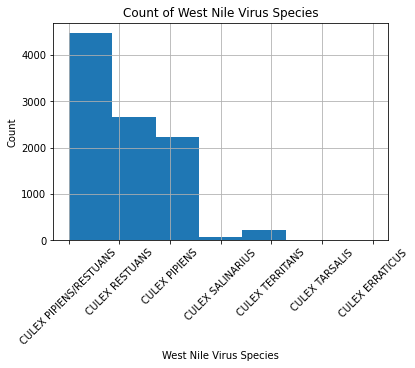

In [67]:
train.Species.hist(bins=7)
plt.xticks(rotation=45)
plt.title('Count of West Nile Virus Species')
plt.xlabel('West Nile Virus Species')
plt.ylabel('Count');

In [68]:
weather.nunique()

Station           2
Date           1472
Tmax             63
Tmin             54
Tavg             66
Depart           41
DewPoint         54
WetBulb          47
Heat             30
Cool             30
Sunrise         121
Sunset          118
CodeSum          98
SnowFall          2
PrecipTotal     166
StnPressure     103
SeaLevel        101
ResultSpeed     190
ResultDir        36
AvgSpeed        177
dtype: int64

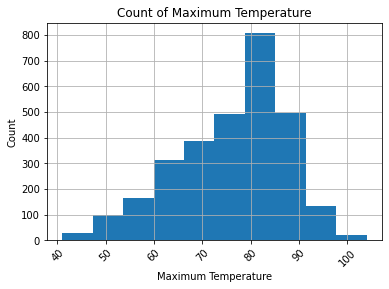

In [69]:
weather.Tmax.hist(bins=10)
plt.xticks(rotation=45)
plt.title('Count of Maximum Temperature')
plt.xlabel('Maximum Temperature')
plt.ylabel('Count');

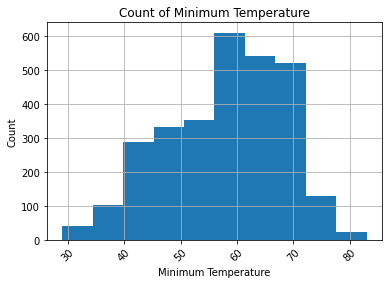

In [70]:
weather.Tmin.hist(bins=10)
plt.xticks(rotation=45)
plt.title('Count of Minimum Temperature')
plt.xlabel('Minimum Temperature')
plt.ylabel('Count');

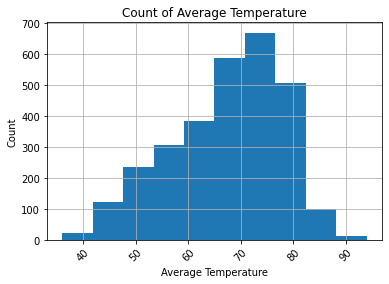

In [71]:
weather.Tavg.hist(bins=10)
plt.xticks(rotation=45)
plt.title('Count of Average Temperature')
plt.xlabel('Average Temperature')
plt.ylabel('Count');

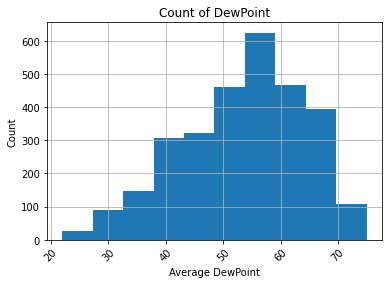

In [72]:
weather.DewPoint.hist(bins=10)
plt.xticks(rotation=45)
plt.title('Count of DewPoint')
plt.xlabel('Average DewPoint')
plt.ylabel('Count');

In [73]:
weather.mode().head(1)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1.0,2007-05-01,84.0,63.0,73.0,2.0,59.0,63.0,0.0,0.0,416.0,1931.0,,0.0,0.0,29.28,30.0,5.9,21.0,6.9


In [74]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   float64
 5   Depart       2944 non-null   float64
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   float64
 8   Heat         2944 non-null   float64
 9   Cool         2944 non-null   float64
 10  Sunrise      2944 non-null   float64
 11  Sunset       2944 non-null   float64
 12  CodeSum      2944 non-null   object 
 13  SnowFall     2944 non-null   float64
 14  PrecipTotal  2944 non-null   float64
 15  StnPressure  2944 non-null   float64
 16  SeaLevel     2944 non-null   float64
 17  ResultSpeed  2944 non-null   float64
 18  ResultDir    2944 non-null   int64  
 19  AvgSpe

In [75]:

weather['Date'] = pd.to_datetime(weather['Date'], format= '%Y/%m/%d')

In [76]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   float64       
 5   Depart       2944 non-null   float64       
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   float64       
 8   Heat         2944 non-null   float64       
 9   Cool         2944 non-null   float64       
 10  Sunrise      2944 non-null   float64       
 11  Sunset       2944 non-null   float64       
 12  CodeSum      2944 non-null   object        
 13  SnowFall     2944 non-null   float64       
 14  PrecipTotal  2944 non-null   float64       
 15  StnPressure  2944 non-null   float64       
 16  SeaLev

In [77]:
weather_scale = weather.loc[:,['Station','Date','Tmax','Tmin','Tavg','Depart','DewPoint','WetBulb','Heat','Cool','Sunrise','Sunset','SnowFall','PrecipTotal','StnPressure','SeaLevel','ResultSpeed','ResultDir','AvgSpeed']]

In [78]:
weather_scale = weather_scale.set_index('Date')
weather_index = weather_scale.index
weather_columns = weather_scale.columns
weather_scale.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67.0,14.0,51,56.0,0.0,2.0,448.0,1849.0,0.0,0.0,29.10,29.82,1.7,27,9.2
2007-05-01,2,84,52,68.0,14.0,51,57.0,0.0,3.0,448.0,1849.0,0.0,0.0,29.18,29.82,2.7,25,9.6
2007-05-02,1,59,42,51.0,-3.0,42,47.0,14.0,0.0,447.0,1850.0,0.0,0.0,29.38,30.09,13.0,4,13.4
2007-05-02,2,60,43,52.0,-3.0,42,47.0,13.0,0.0,447.0,1850.0,0.0,0.0,29.44,30.08,13.3,2,13.4
2007-05-03,1,66,46,56.0,2.0,40,48.0,9.0,0.0,446.0,1851.0,0.0,0.0,29.39,30.12,11.7,7,11.9


In [79]:
weather_scale.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67.0,14.0,51,56.0,0.0,2.0,448.0,1849.0,0.0,0.0,29.10,29.82,1.7,27,9.2
2007-05-01,2,84,52,68.0,14.0,51,57.0,0.0,3.0,448.0,1849.0,0.0,0.0,29.18,29.82,2.7,25,9.6
2007-05-02,1,59,42,51.0,-3.0,42,47.0,14.0,0.0,447.0,1850.0,0.0,0.0,29.38,30.09,13.0,4,13.4
2007-05-02,2,60,43,52.0,-3.0,42,47.0,13.0,0.0,447.0,1850.0,0.0,0.0,29.44,30.08,13.3,2,13.4
2007-05-03,1,66,46,56.0,2.0,40,48.0,9.0,0.0,446.0,1851.0,0.0,0.0,29.39,30.12,11.7,7,11.9


In [80]:
weather_scale = scale(weather_scale)

In [81]:
weather_scaled_df = pd.DataFrame(weather_scale, columns=weather_columns)
weather_scaled_df.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,-1.0,0.596325,-0.752440,-0.022710,1.761353,-0.230282,-0.357060,-0.570990,-0.597520,-0.499778,0.018986,-0.018433,-0.333823,-1.164219,-0.935627,-1.466626,0.944662,0.197139
1,1.0,0.683585,-0.559765,0.072193,1.761353,-0.230282,-0.249290,-0.570990,-0.433410,-0.499778,0.018986,-0.018433,-0.333823,-0.659197,-0.935627,-1.187835,0.745892,0.324317
2,-1.0,-1.497912,-1.523140,-1.541170,-0.724468,-1.073502,-1.326986,1.784051,-0.925741,-0.515086,0.030477,-0.018433,-0.333823,0.603359,0.769703,1.683711,-1.341189,1.532508
3,1.0,-1.410652,-1.426803,-1.446266,-0.724468,-1.073502,-1.326986,1.615834,-0.925741,-0.515086,0.030477,-0.018433,-0.333823,0.982126,0.706542,1.767349,-1.539958,1.532508
4,-1.0,-0.887093,-1.137790,-1.066651,0.006656,-1.260884,-1.219216,0.942965,-0.925741,-0.530395,0.041969,-0.018433,-0.333823,0.666487,0.959184,1.321283,-1.043034,1.055590


In [82]:
weather_scaled_df.mean()

Station        0.000000e+00
Tmax          -4.973377e-16
Tmin          -2.965623e-16
Tavg           4.698838e-16
Depart        -1.748300e-16
DewPoint      -5.430439e-18
WetBulb       -1.976076e-17
Heat          -9.610368e-16
Cool           4.868539e-16
Sunrise       -6.208802e-16
Sunset        -2.304920e-16
SnowFall      -7.135912e-16
PrecipTotal   -7.523420e-18
StnPressure    1.420414e-14
SeaLevel      -5.736655e-15
ResultSpeed    3.016910e-19
ResultDir      1.116257e-17
AvgSpeed       4.857226e-16
dtype: float64

In [83]:
weather_scaled_df.std()

Station        1.00017
Tmax           1.00017
Tmin           1.00017
Tavg           1.00017
Depart         1.00017
DewPoint       1.00017
WetBulb        1.00017
Heat           1.00017
Cool           1.00017
Sunrise        1.00017
Sunset         1.00017
SnowFall       1.00017
PrecipTotal    1.00017
StnPressure    1.00017
SeaLevel       1.00017
ResultSpeed    1.00017
ResultDir      1.00017
AvgSpeed       1.00017
dtype: float64

In [84]:
weather_scaled_df.std(ddof=0)

Station        1.0
Tmax           1.0
Tmin           1.0
Tavg           1.0
Depart         1.0
DewPoint       1.0
WetBulb        1.0
Heat           1.0
Cool           1.0
Sunrise        1.0
Sunset         1.0
SnowFall       1.0
PrecipTotal    1.0
StnPressure    1.0
SeaLevel       1.0
ResultSpeed    1.0
ResultDir      1.0
AvgSpeed       1.0
dtype: float64

In [85]:
weather_pca = PCA().fit(weather_scale)

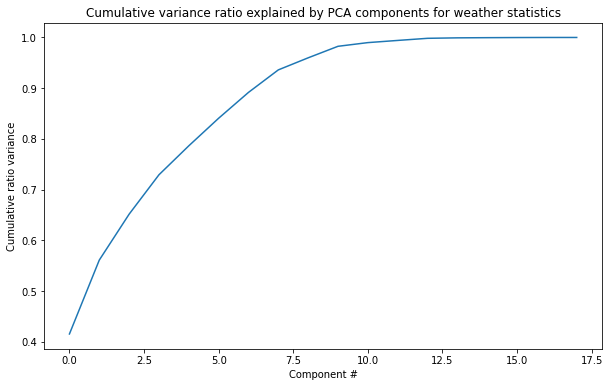

In [86]:
plt.subplots(figsize=(10, 6))
plt.plot(weather_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for weather statistics');

In [87]:
weather_pca_x = weather_pca.transform(weather_scale)

In [88]:
weather_pca_x.shape

(2944, 18)

In [89]:
pca_df = pd.DataFrame({'PC1': weather_pca_x[:, 0], 'PC2': weather_pca_x[:, 1]}, index=weather_index) #QUESTION: Why can't we just use the x and y variables that were assigned to this originally?
pca_df.head()

,PC1,PC2
Date,,
2007-05-01,-0.553033,0.761036
2007-05-01,-0.721652,0.529628
2007-05-02,3.724187,0.760775
2007-05-02,3.584352,0.459738
2007-05-03,2.777731,0.261173


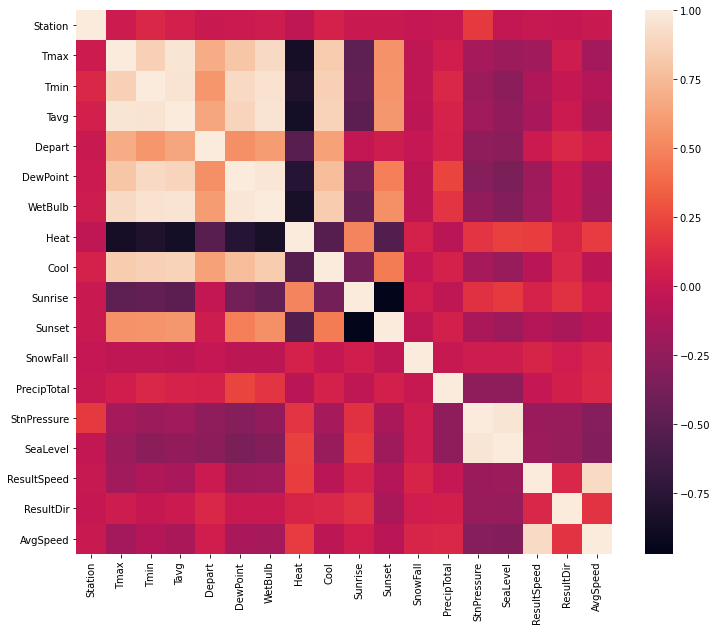

In [90]:
plt.subplots(figsize=(12,10))
sns.heatmap(weather.corr());

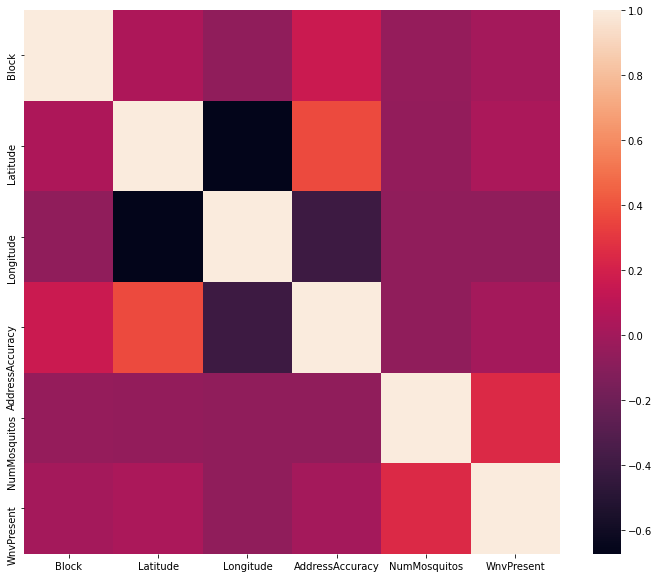

In [91]:
plt.subplots(figsize=(12,10))
sns.heatmap(train.corr());

In [92]:
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'Tmax', data=weather, alpha=0.5)
        ax.set(xlabel=col, ylabel='Max Temp')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [93]:
features = [item for item in weather.columns if item not in ['Date','ResultDir', 'AvgSpeed', 'ResultSPeed','CodeSum']]


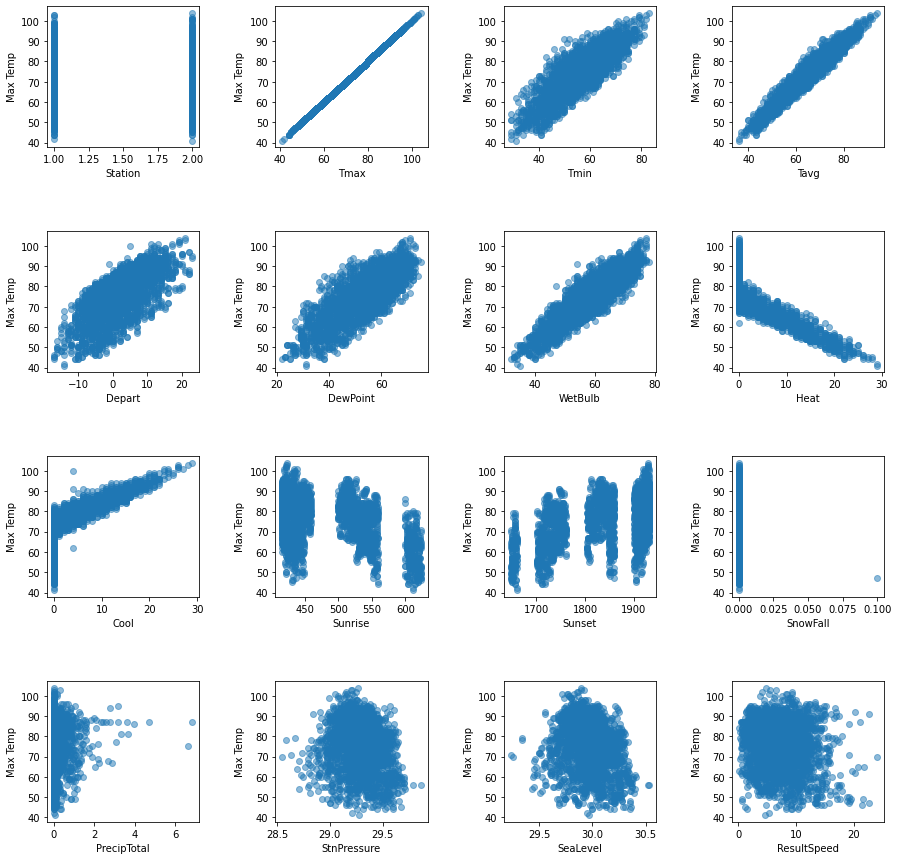

In [94]:
scatterplots(features, ncol=4, figsize=(15, 15))

EDA Conclusion: There seems to be a strong positive correlation between Tmax, Tmin, Tavg, DewPoint, WetBulb, and Cool. There is a very strong negative correlation for those listed (except Cool) with Heat.

**FEATURE ENGINEERING**

In [95]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [96]:
train['Date'] = pd.to_datetime(train['Date'], format= '%Y/%m/%d')
test['Date'] = pd.to_datetime(test['Date'], format= '%Y/%m/%d')
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [97]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [98]:
test_function = haversine(87.800991,41.95469,87.824812,41.974089)
test_function


2.9209549484622293

In [99]:
weather2 = weather[weather.Station != 2]
weather2.head()


,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,448.0,1849.0,,0.0,0.0,29.10,29.82,1.7,27,9.2
2,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,447.0,1850.0,BR,0.0,0.0,29.38,30.09,13.0,4,13.4
4,1,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,446.0,1851.0,,0.0,0.0,29.39,30.12,11.7,7,11.9
6,1,2007-05-04,66,49,58.0,4.0,41,50.0,7.0,0.0,444.0,1852.0,RA,0.0,0.0,29.31,30.05,10.4,8,10.8
8,1,2007-05-05,66,53,60.0,5.0,38,49.0,5.0,0.0,443.0,1853.0,,0.0,0.0,29.40,30.10,11.7,7,12.0


In [100]:
train_weather = train.merge(weather2, how='inner', left_on=['Date'], right_on=['Date'])
train_weather.head().T

,0,1,2,3,4
Date,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00
Address,"4100 North Oak Park Avenue, Chicago, IL 60634,...","4100 North Oak Park Avenue, Chicago, IL 60634,...","6200 North Mandell Avenue, Chicago, IL 60646, USA","7900 West Foster Avenue, Chicago, IL 60656, USA","7900 West Foster Avenue, Chicago, IL 60656, USA"
Species,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX RESTUANS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS
Block,41,41,62,79,79
Street,N OAK PARK AVE,N OAK PARK AVE,N MANDELL AVE,W FOSTER AVE,W FOSTER AVE
Trap,T002,T002,T007,T015,T015
AddressNumberAndStreet,"4100 N OAK PARK AVE, Chicago, IL","4100 N OAK PARK AVE, Chicago, IL","6200 N MANDELL AVE, Chicago, IL","7900 W FOSTER AVE, Chicago, IL","7900 W FOSTER AVE, Chicago, IL"
Latitude,41.9547,41.9547,41.995,41.9741,41.9741
Longitude,-87.801,-87.801,-87.7693,-87.8248,-87.8248
AddressAccuracy,9,9,9,8,8


In [101]:
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'Tmax', data=train_weather, alpha=0.5)
        ax.set(xlabel=col, ylabel='Max Temp')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [102]:
features2 = [item for item in train_weather.columns if item not in ['Date','Species','ResultDir','Address','Trap','AddressNumberAndStreet','Latitude','Longitude','Street','Block','NumMosquitos', 'AvgSpeed', 'ResultSPeed','CodeSum']]

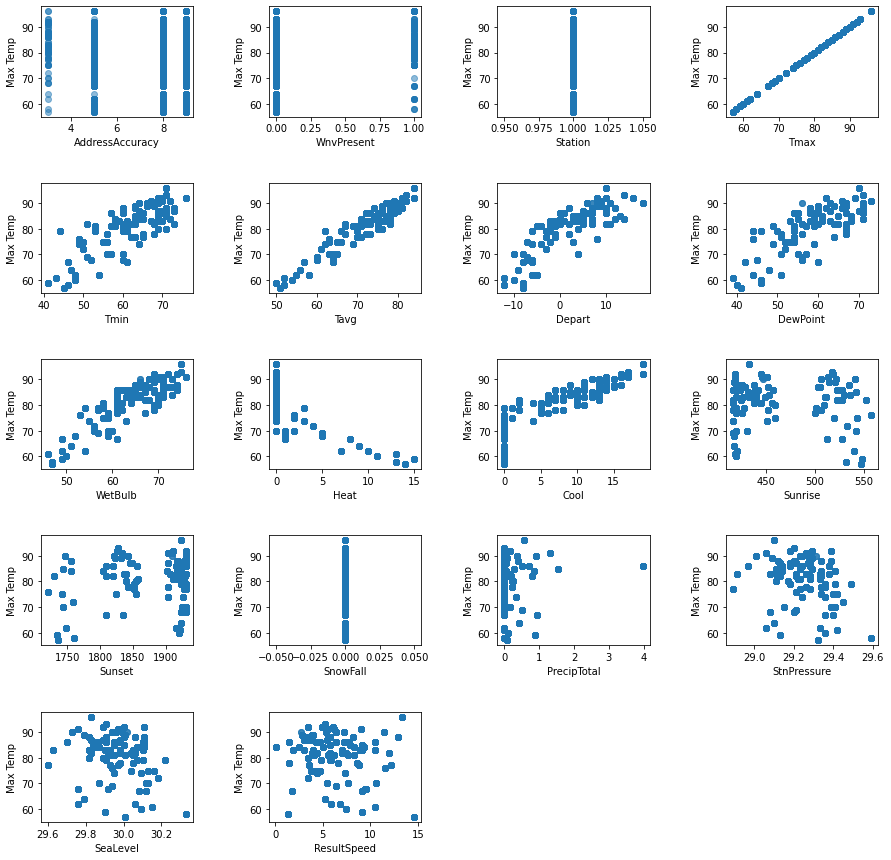

In [103]:
scatterplots(features2, ncol=4, figsize=(15, 15))

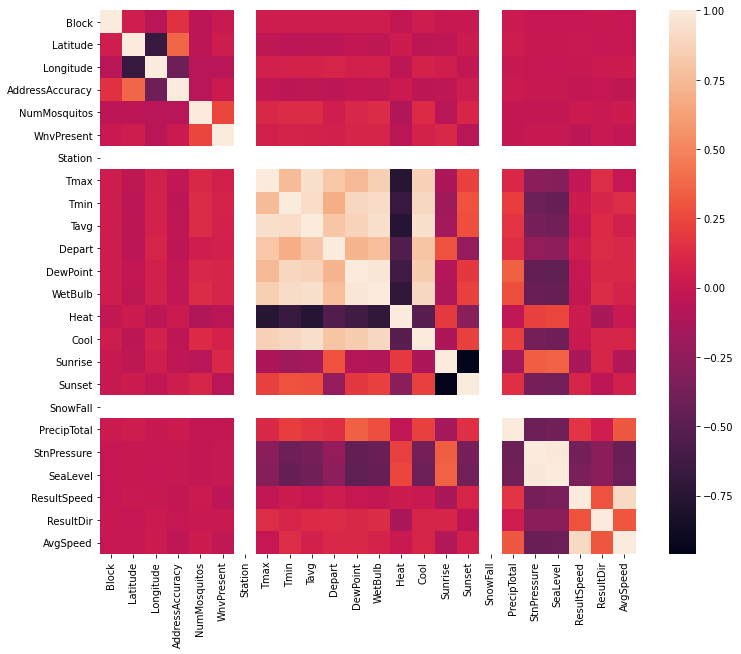

In [104]:
plt.subplots(figsize=(12,10))
corr = train_weather.corr(method='pearson')
sns.heatmap(train_weather.corr());

In [105]:
#compression_opts = dict(method='zip',
#                        archive_name='train_weather.csv')  
#train_weather.to_csv('train_weather.zip', index=False,
#          compression=compression_opts)  

In [106]:
train_weather['Station'].nunique()

1

In [107]:
#Formula for relative humidity at https://www.wikihow.com/Calculate-Humidity

def relative_humidity(Tavg,DewPoint):
    Tavg_C= (Tavg-32) * 5/9
    DewPoint_C = (DewPoint -32) * 5/9
    sat_vapor_pressure = 6.11*10**(7.5*Tavg_C/(237.7+Tavg_C))
    actual_pressure= 6.11*10**(7.5*DewPoint_C/(237.7+DewPoint_C))
    
    return round(((actual_pressure/sat_vapor_pressure)*100),2)

train_weather['Relative_Humidity'] = relative_humidity(train_weather['Tavg'],train_weather['DewPoint'])
train_weather.head().T


,0,1,2,3,4
Date,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00
Address,"4100 North Oak Park Avenue, Chicago, IL 60634,...","4100 North Oak Park Avenue, Chicago, IL 60634,...","6200 North Mandell Avenue, Chicago, IL 60646, USA","7900 West Foster Avenue, Chicago, IL 60656, USA","7900 West Foster Avenue, Chicago, IL 60656, USA"
Species,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX RESTUANS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS
Block,41,41,62,79,79
Street,N OAK PARK AVE,N OAK PARK AVE,N MANDELL AVE,W FOSTER AVE,W FOSTER AVE
Trap,T002,T002,T007,T015,T015
AddressNumberAndStreet,"4100 N OAK PARK AVE, Chicago, IL","4100 N OAK PARK AVE, Chicago, IL","6200 N MANDELL AVE, Chicago, IL","7900 W FOSTER AVE, Chicago, IL","7900 W FOSTER AVE, Chicago, IL"
Latitude,41.9547,41.9547,41.995,41.9741,41.9741
Longitude,-87.801,-87.801,-87.7693,-87.8248,-87.8248
AddressAccuracy,9,9,9,8,8


In [108]:
new_df = pd.get_dummies(train_weather, columns=['Species'])
new_df.head().T

,0,1,2,3,4
Date,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00,2007-05-29 00:00:00
Address,"4100 North Oak Park Avenue, Chicago, IL 60634,...","4100 North Oak Park Avenue, Chicago, IL 60634,...","6200 North Mandell Avenue, Chicago, IL 60646, USA","7900 West Foster Avenue, Chicago, IL 60656, USA","7900 West Foster Avenue, Chicago, IL 60656, USA"
Block,41,41,62,79,79
Street,N OAK PARK AVE,N OAK PARK AVE,N MANDELL AVE,W FOSTER AVE,W FOSTER AVE
Trap,T002,T002,T007,T015,T015
AddressNumberAndStreet,"4100 N OAK PARK AVE, Chicago, IL","4100 N OAK PARK AVE, Chicago, IL","6200 N MANDELL AVE, Chicago, IL","7900 W FOSTER AVE, Chicago, IL","7900 W FOSTER AVE, Chicago, IL"
Latitude,41.9547,41.9547,41.995,41.9741,41.9741
Longitude,-87.801,-87.801,-87.7693,-87.8248,-87.8248
AddressAccuracy,9,9,9,8,8
NumMosquitos,1,1,1,1,4


In [109]:
table1 = pd.pivot_table(train_weather, values='NumMosquitos', index=['Species'],
                    columns=['WnvPresent'], aggfunc=np.sum)
table1

WnvPresent,0,1
Species,,
CULEX ERRATICUS,7.0,NaN
CULEX PIPIENS,18109.0,5129.0
CULEX PIPIENS/RESTUANS,47339.0,6352.0
CULEX RESTUANS,20709.0,667.0
CULEX SALINARIUS,144.0,NaN
CULEX TARSALIS,7.0,NaN
CULEX TERRITANS,508.0,NaN


In [110]:
table2 = pd.pivot_table(new_df, index=['WnvPresent'],
                    values=['Tmax','Tavg','Tmin','Relative_Humidity','DewPoint','WetBulb'], aggfunc=np.mean)
table2

,DewPoint,Relative_Humidity,Tavg,Tmax,Tmin,WetBulb
WnvPresent,,,,,,
0,59.303917,64.806461,72.067465,81.420022,62.219260,64.181610
1,62.590457,66.819920,74.532803,83.514911,64.970179,66.920477


In [111]:
mask = ~(new_df.columns.isin(['WnvPresent']))
cols_to_shift = new_df.columns[mask]
new_df[cols_to_shift] = new_df.loc[:,mask].shift(-1)
new_df.head()

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,...,ResultDir,AvgSpeed,Relative_Humidity,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9.0,1.0,...,18.0,6.5,57.44,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",62.0,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9.0,1.0,...,18.0,6.5,57.44,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79.0,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8.0,1.0,...,18.0,6.5,57.44,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79.0,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8.0,4.0,...,18.0,6.5,57.44,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",15.0,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8.0,2.0,...,18.0,6.5,57.44,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [112]:
new_df['Month']=new_df['Date'].dt.month
new_df['Year']=new_df['Date'].dt.year

In [113]:
def create_season(month):
    if 3<=month<=5: season = 'Spring'
    elif 6<=month<=8: season = 'Summer'
    elif 9<=month<=11: season = 'Fall'
    else: season = 'Winter'
    return(season)
new_df['Season'] = new_df['Month'].apply(create_season)

new_df.head()

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,...,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Month,Year,Season
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,2007.0,Spring
1,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",62.0,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,2007.0,Spring
2,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79.0,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,2007.0,Spring
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79.0,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,2007.0,Spring
4,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",15.0,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,2007.0,Spring


In [114]:
table3 = pd.pivot_table(new_df, values=['NumMosquitos'], index=['WnvPresent','Season'],
                    columns=['Year'], aggfunc=np.sum)
table3
        

NumMosquitos                           
Year                    2007.0   2009.0   2011.0   2013.0
WnvPresent Season                                        
0          Fall         6575.0   2262.0   3110.0   4956.0
           Spring         39.0    187.0      NaN      NaN
           Summer      22044.0  14334.0  13112.0  24065.0
1          Fall          278.0     12.0    215.0   1177.0
           Summer       2906.0    163.0    354.0   3181.0